In [4]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import matplotlib.colors as mcolors
from datetime import datetime, timedelta
from matplotlib.patches import Patch
# from cpg_cliff_plotting import *
import json
import numpy as np
from collections import defaultdict

##### Code for plotting the distribution of erosion object sizes across all locations

In [ ]:
def analyze_cluster_volumes(location="Delmar"):
    """
    Load erosion and cluster data cubes, calculate volumes for each cluster across all time steps,
    and create a histogram of cluster volumes.
    """
    
    # Load the data cubes
    base_path = f"/Volumes/group/LiDAR/LidarProcessing/LidarProcessingCliffs/results/{location}/data_cubes"
    
    print("Loading data cubes...")
    erosion_data = np.load(f"{base_path}/cube_ero_10cm_filled.npz")['data']
    cluster_data = np.load(f"{base_path}/cube_clusters_ero_10cm_filled.npz")['data']
    
    print(f"Erosion cube shape: {erosion_data.shape}")
    print(f"Cluster cube shape: {cluster_data.shape}")
    
    # Load file lists for time step reference
    with open(f"{base_path}/files_ero.json", "r") as f:
        ero_files = json.load(f)
    
    with open(f"{base_path}/files_clusters_ero.json", "r") as f:
        cluster_files = json.load(f)
    
    print(f"Number of time steps: {len(ero_files)}")
    
    # Dictionary to store volumes for each cluster across all time steps
    cluster_volumes = defaultdict(list)
    
    print("Calculating cluster volumes...")
    
    # Process each time step
    for t in range(erosion_data.shape[0]):
        erosion_slice = erosion_data[t]
        cluster_slice = cluster_data[t]
        
        # Get unique cluster IDs (excluding 0 which typically means no cluster)
        unique_clusters = np.unique(cluster_slice)
        unique_clusters = unique_clusters[unique_clusters > 0]  # Remove 0 and negative values
        unique_clusters = unique_clusters.astype(int)  # Convert to integers to fix formatting error
        
        # Calculate volume for each cluster at this time step
        for cluster_id in unique_clusters:
            # Find all points belonging to this cluster
            cluster_mask = (cluster_slice == cluster_id)
            
            # Sum erosion values for this cluster and convert to volume
            # Multiply by 0.01 to convert from cm to m (since grid is 10cm resolution)
            cluster_erosion_sum = np.sum(erosion_slice[cluster_mask])
            cluster_volume = cluster_erosion_sum * 0.01  # Convert to m³
            
            # Only include positive volumes (actual erosion)
            if cluster_volume > 0:
                cluster_volumes[cluster_id].append(cluster_volume)
    
    print(f"Found {len(cluster_volumes)} unique clusters with erosion")
    
    # Flatten all volumes into a single list for histogram
    all_volumes = []
    cluster_stats = {}
    
    for cluster_id, volumes in cluster_volumes.items():
        all_volumes.extend(volumes)
        cluster_stats[cluster_id] = {
            'count': len(volumes),
            'total_volume': sum(volumes),
            'mean_volume': np.mean(volumes),
            'max_volume': max(volumes)
        }
    
    print(f"Total number of cluster-time observations: {len(all_volumes)}")
    print(f"Total volume across all clusters: {sum(all_volumes):.2f} m³")
    
    # Calculate percentile thresholds
    p90_threshold = np.percentile(all_volumes, 90)
    p95_threshold = np.percentile(all_volumes, 95)
    p975_threshold = np.percentile(all_volumes, 97.5)
    
    # Filter clusters above 97.5th percentile
    above_975th = [(cid, stats) for cid, stats in cluster_stats.items() 
                   if stats['total_volume'] >= p975_threshold]
    above_975th = sorted(above_975th, key=lambda x: x[1]['total_volume'], reverse=True)
    
    # Create figure with custom layout: histogram on top, boxplot below, bar chart on right
    fig = plt.figure(figsize=(20, 8))
    
    # Create gridspec for custom layout with more space between histogram and boxplot
    gs = fig.add_gridspec(2, 2, height_ratios=[3, 1], width_ratios=[1, 1], hspace=0.2, wspace=0.3)
    
    # Top left: Histogram with log-log scale
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.hist(all_volumes, bins=50, alpha=0.7, color='lightgray', edgecolor='black')
    ax1.set_ylabel('Frequency', fontsize=16, fontweight='bold')
    ax1.set_title(f'Distribution of Cluster Volumes - {location}', fontsize=20, fontweight='bold')
    ax1.set_xscale('log')  # Log scale for x-axis
    ax1.set_yscale('log')  # Log scale for y-axis
    ax1.grid(True, alpha=0.3)
    
    # Add only 97.5th percentile line to histogram
    ax1.axvline(p975_threshold, color='darkred', linestyle='--', alpha=0.8, linewidth=2, 
                label=f'97.5th percentile ({p975_threshold:.3f} m³)')
    ax1.legend()
    
    # Remove x-axis labels from histogram (will be on boxplot below)
    ax1.set_xticklabels([])
    
    # Bottom left: Boxplot (sharing x-axis with histogram)
    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
    box_data = ax2.boxplot(all_volumes, vert=False, patch_artist=True, widths=0.6)
    box_data['boxes'][0].set_facecolor('lightgray')
    box_data['boxes'][0].set_alpha(0.7)
    
    # Customize boxplot appearance
    for element in ['whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(box_data[element], color='black', linewidth=1.5)
    
    ax2.set_xlabel('Cluster Volume (m³)', fontsize=16, fontweight='bold')
    ax2.set_xscale('log')  # Log scale for better visualization
    ax2.grid(True, alpha=0.3, axis='x')
    ax2.set_yticklabels([])  # Remove y-axis labels for boxplot
    
    # Right side: Bar chart spanning both rows - showing only events above 97.5th percentile
    ax3 = fig.add_subplot(gs[:, 1])
    cluster_ids_975th = [str(x[0]) for x in above_975th]
    total_volumes_975th = [x[1]['total_volume'] for x in above_975th]
    
    if total_volumes_975th:  # Only plot if there are clusters above 97.5th percentile
        bars = ax3.bar(range(len(cluster_ids_975th)), total_volumes_975th, color='darkred', alpha=0.7)
        ax3.set_xlabel('Cluster Rank', fontsize=16, fontweight='bold')
        ax3.set_ylabel('Total Volume (m³)', fontsize=16, fontweight='bold')
        ax3.set_title(f'Clusters Above 97.5th Percentile ({len(above_975th)} clusters)', fontsize=20, fontweight='bold')
        
        # Set x-ticks - adjust spacing based on number of clusters
        if len(cluster_ids_975th) > 0:
            tick_spacing = max(1, len(cluster_ids_975th) // 10)  # Show at most 10 ticks
            x_tick_positions = range(0, len(cluster_ids_975th), tick_spacing)
            x_tick_labels = [cluster_ids_975th[i] for i in x_tick_positions]
            ax3.set_xticks(x_tick_positions)
            ax3.set_xticklabels(x_tick_labels, rotation=45, ha='right')
        
        # Add grid for better readability
        ax3.grid(True, alpha=0.3, axis='y')
        
        # All bars same color - removed highlighting code
        
    else:
        ax3.text(0.5, 0.5, 'No clusters above\n97.5th percentile', 
                 horizontalalignment='center', verticalalignment='center', 
                 transform=ax3.transAxes, fontsize=16, fontweight='bold')
        ax3.set_title('Clusters Above 97.5th Percentile (0 clusters)', fontsize=20, fontweight='bold')
    
    plt.tight_layout()
    # plt.savefig(f'{location}_cluster_volume_analysis_histogram_boxplot.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary statistics
    print(f"\n--- Summary Statistics ---")
    print(f"Total clusters: {len(cluster_volumes)}")
    print(f"Total observations: {len(all_volumes)}")
    print(f"Mean volume per observation: {np.mean(all_volumes):.4f} m³")
    print(f"Median volume: {np.median(all_volumes):.4f} m³")
    print(f"Standard deviation: {np.std(all_volumes):.4f} m³")
    print(f"Max volume: {np.max(all_volumes):.4f} m³")
    print(f"Min volume: {np.min(all_volumes):.4f} m³")
    print(f"25th percentile (Q1): {np.percentile(all_volumes, 25):.4f} m³")
    print(f"75th percentile (Q3): {np.percentile(all_volumes, 75):.4f} m³")
    print(f"90th percentile: {p90_threshold:.4f} m³")
    print(f"95th percentile: {p95_threshold:.4f} m³")
    print(f"97.5th percentile: {p975_threshold:.4f} m³")
    print(f"Interquartile Range (IQR): {np.percentile(all_volumes, 75) - np.percentile(all_volumes, 25):.4f} m³")
    
    print(f"\n--- Clusters Above 97.5th Percentile ({len(above_975th)} total) ---")
    print(f"97.5th percentile threshold: {p975_threshold:.4f} m³")
    
    print(f"\n--- Top 10 Clusters by Total Volume (Above 97.5th Percentile) ---")
    top_10_display = above_975th[:10] if len(above_975th) >= 10 else above_975th
    for i, (cluster_id, stats) in enumerate(top_10_display):
        print(f"{i+1:2d}. Cluster {cluster_id:4d}: {stats['total_volume']:8.3f} m³ "
              f"({stats['count']:3d} observations, mean: {stats['mean_volume']:.4f} m³)")
    
    return cluster_volumes, cluster_stats, all_volumes

Loading data cubes...
Erosion cube shape: (321, 22850, 300)
Cluster cube shape: (321, 22850, 300)
Number of time steps: 321
Calculating cluster volumes...
Found 976 unique clusters with erosion
Total number of cluster-time observations: 13510
Total volume across all clusters: 25372.12 m³


/var/folders/wy/tbzk6rdx0_5d5y5p18xzqyfm0000gn/T/ipykernel_29584/3359318799.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


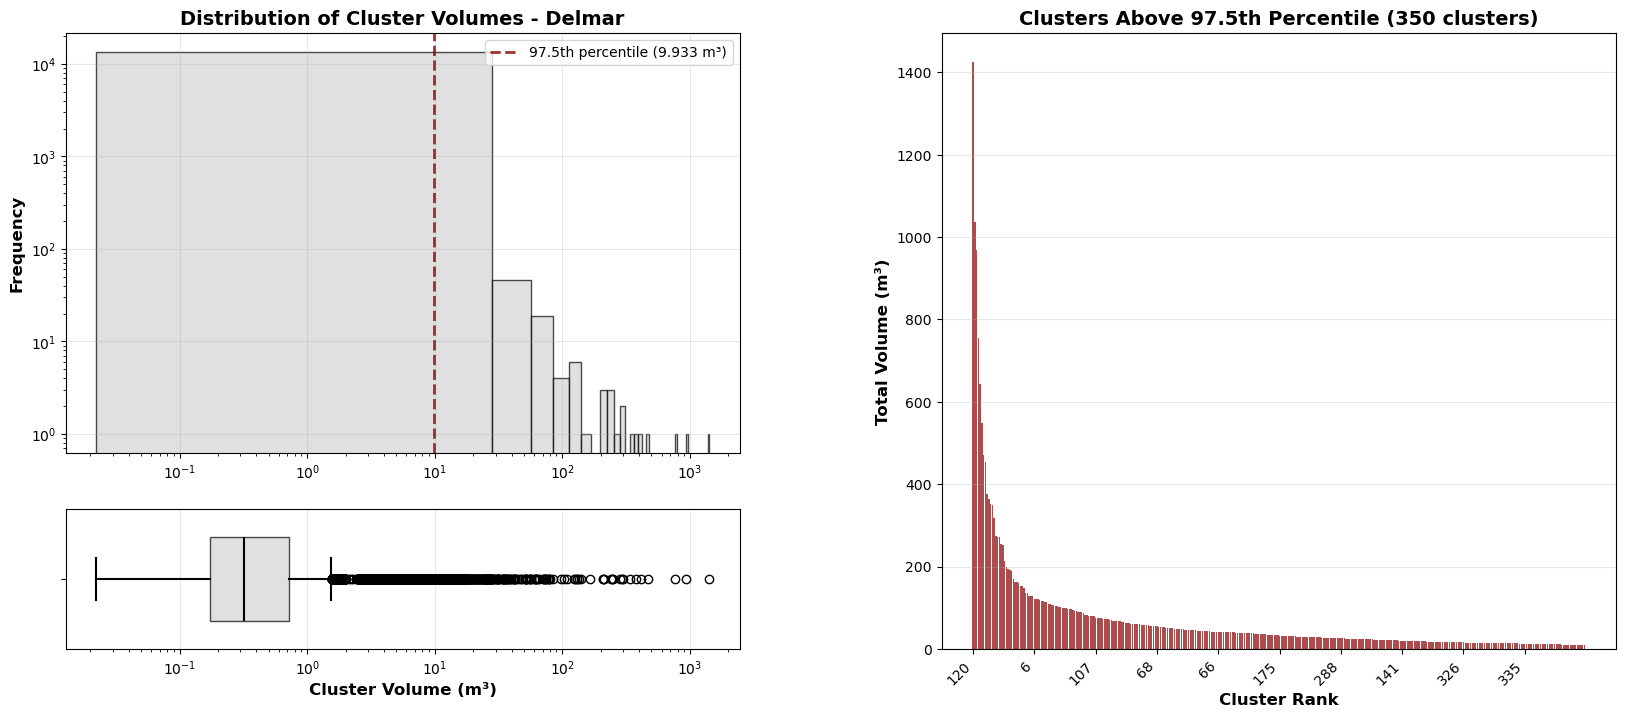


--- Summary Statistics ---
Total clusters: 976
Total observations: 13510
Mean volume per observation: 1.8780 m³
Median volume: 0.3212 m³
Standard deviation: 19.3249 m³
Max volume: 1410.4714 m³
Min volume: 0.0222 m³
25th percentile (Q1): 0.1735 m³
75th percentile (Q3): 0.7242 m³
90th percentile: 1.8193 m³
95th percentile: 5.5985 m³
97.5th percentile: 9.9333 m³
Interquartile Range (IQR): 0.5507 m³

--- Clusters Above 97.5th Percentile (350 total) ---
97.5th percentile threshold: 9.9333 m³

--- Top 10 Clusters by Total Volume (Above 97.5th Percentile) ---
 1. Cluster  120: 1424.384 m³ ( 27 observations, mean: 52.7549 m³)
 2. Cluster    5: 1037.118 m³ (105 observations, mean: 9.8773 m³)
 3. Cluster   25:  967.872 m³ ( 85 observations, mean: 11.3867 m³)
 4. Cluster   16:  755.942 m³ (115 observations, mean: 6.5734 m³)
 5. Cluster   29:  644.042 m³ ( 75 observations, mean: 8.5872 m³)
 6. Cluster    1:  548.304 m³ ( 92 observations, mean: 5.9598 m³)
 7. Cluster   17:  469.963 m³ (112 observa

In [13]:
cluster_volumes_dm, cluster_stats_dm, all_volumes_dm = analyze_cluster_volumes("Delmar")

Loading data cubes...
Erosion cube shape: (301, 12888, 750)
Cluster cube shape: (301, 12888, 750)
Number of time steps: 301
Calculating cluster volumes...
Found 4039 unique clusters with erosion
Total number of cluster-time observations: 17983
Total volume across all clusters: 29723.14 m³


/var/folders/wy/tbzk6rdx0_5d5y5p18xzqyfm0000gn/T/ipykernel_29584/3359318799.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


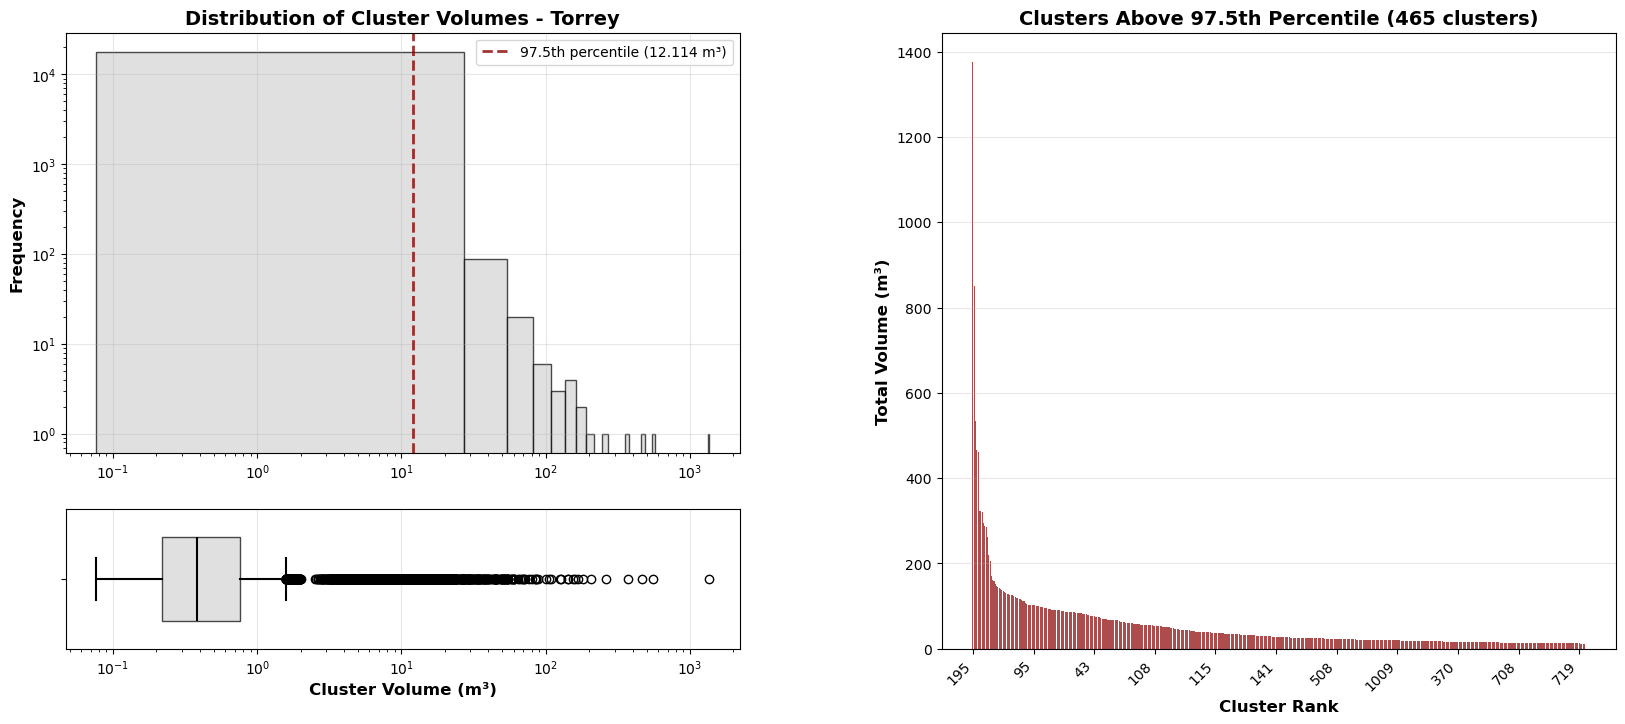


--- Summary Statistics ---
Total clusters: 4039
Total observations: 17983
Mean volume per observation: 1.6528 m³
Median volume: 0.3851 m³
Standard deviation: 13.2932 m³
Max volume: 1353.8404 m³
Min volume: 0.0767 m³
25th percentile (Q1): 0.2198 m³
75th percentile (Q3): 0.7608 m³
90th percentile: 1.6041 m³
95th percentile: 6.7436 m³
97.5th percentile: 12.1138 m³
Interquartile Range (IQR): 0.5410 m³

--- Clusters Above 97.5th Percentile (465 total) ---
97.5th percentile threshold: 12.1138 m³

--- Top 10 Clusters by Total Volume (Above 97.5th Percentile) ---
 1. Cluster  195: 1375.642 m³ ( 24 observations, mean: 57.3184 m³)
 2. Cluster   29:  850.515 m³ ( 89 observations, mean: 9.5564 m³)
 3. Cluster   41:  534.408 m³ ( 83 observations, mean: 6.4387 m³)
 4. Cluster  407:  466.437 m³ (  2 observations, mean: 233.2185 m³)
 5. Cluster   25:  460.467 m³ ( 79 observations, mean: 5.8287 m³)
 6. Cluster   21:  324.034 m³ ( 91 observations, mean: 3.5608 m³)
 7. Cluster    7:  323.208 m³ ( 77 obs

/var/folders/wy/tbzk6rdx0_5d5y5p18xzqyfm0000gn/T/ipykernel_29584/3359318799.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


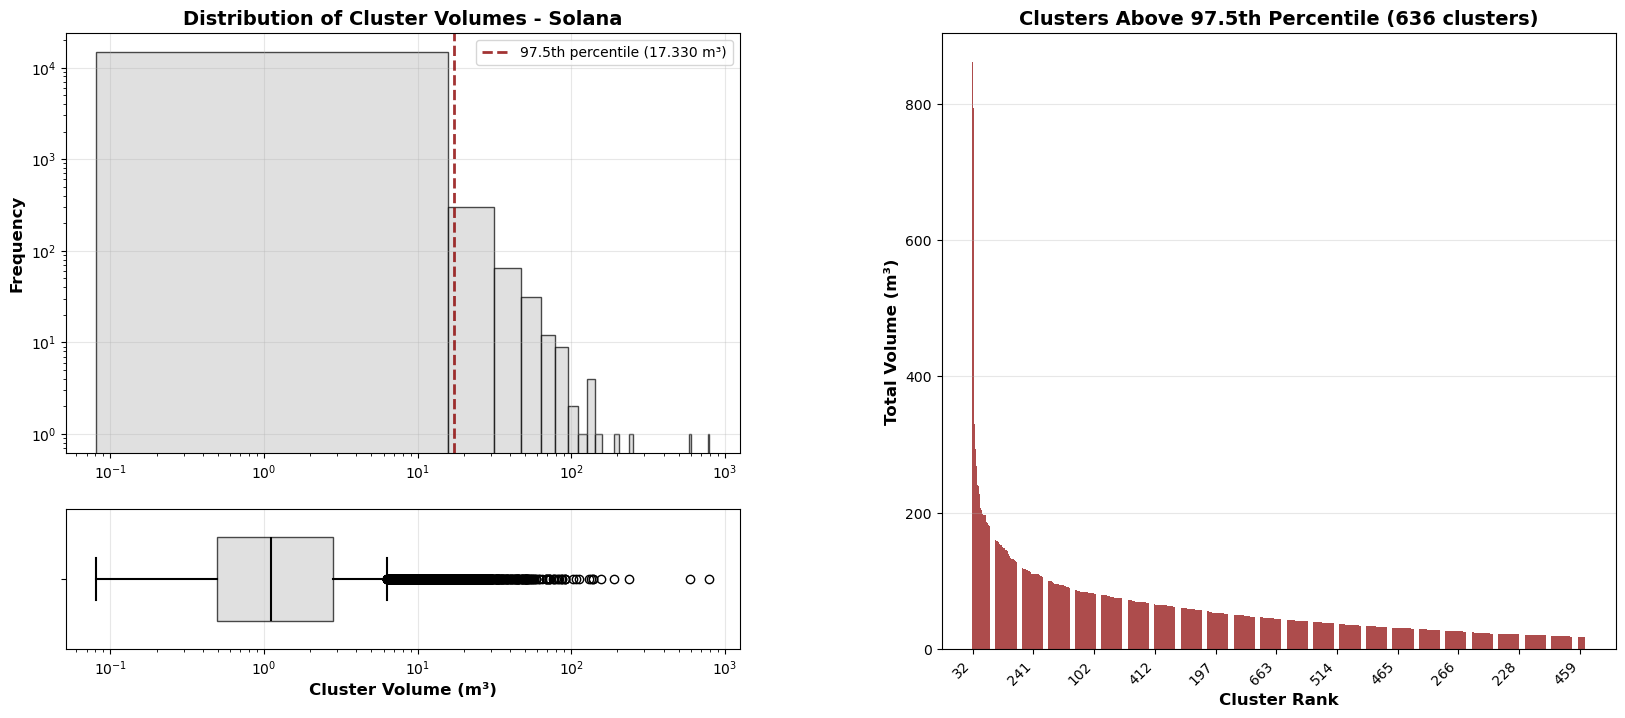


--- Summary Statistics ---
Total clusters: 3408
Total observations: 15184
Mean volume per observation: 3.0587 m³
Median volume: 1.1130 m³
Standard deviation: 10.5497 m³
Max volume: 788.1854 m³
Min volume: 0.0810 m³
25th percentile (Q1): 0.4956 m³
75th percentile (Q3): 2.8339 m³
90th percentile: 6.6457 m³
95th percentile: 10.8443 m³
97.5th percentile: 17.3298 m³
Interquartile Range (IQR): 2.3384 m³

--- Clusters Above 97.5th Percentile (636 total) ---
97.5th percentile threshold: 17.3298 m³

--- Top 10 Clusters by Total Volume (Above 97.5th Percentile) ---
 1. Cluster   32:  860.878 m³ ( 44 observations, mean: 19.5654 m³)
 2. Cluster   36:  793.697 m³ ( 43 observations, mean: 18.4581 m³)
 3. Cluster   34:  330.859 m³ ( 41 observations, mean: 8.0697 m³)
 4. Cluster   49:  294.208 m³ ( 44 observations, mean: 6.6866 m³)
 5. Cluster   30:  268.780 m³ ( 42 observations, mean: 6.3995 m³)
 6. Cluster   47:  240.315 m³ ( 36 observations, mean: 6.6754 m³)
 7. Cluster   57:  239.776 m³ ( 34 obse

/var/folders/wy/tbzk6rdx0_5d5y5p18xzqyfm0000gn/T/ipykernel_29584/3359318799.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


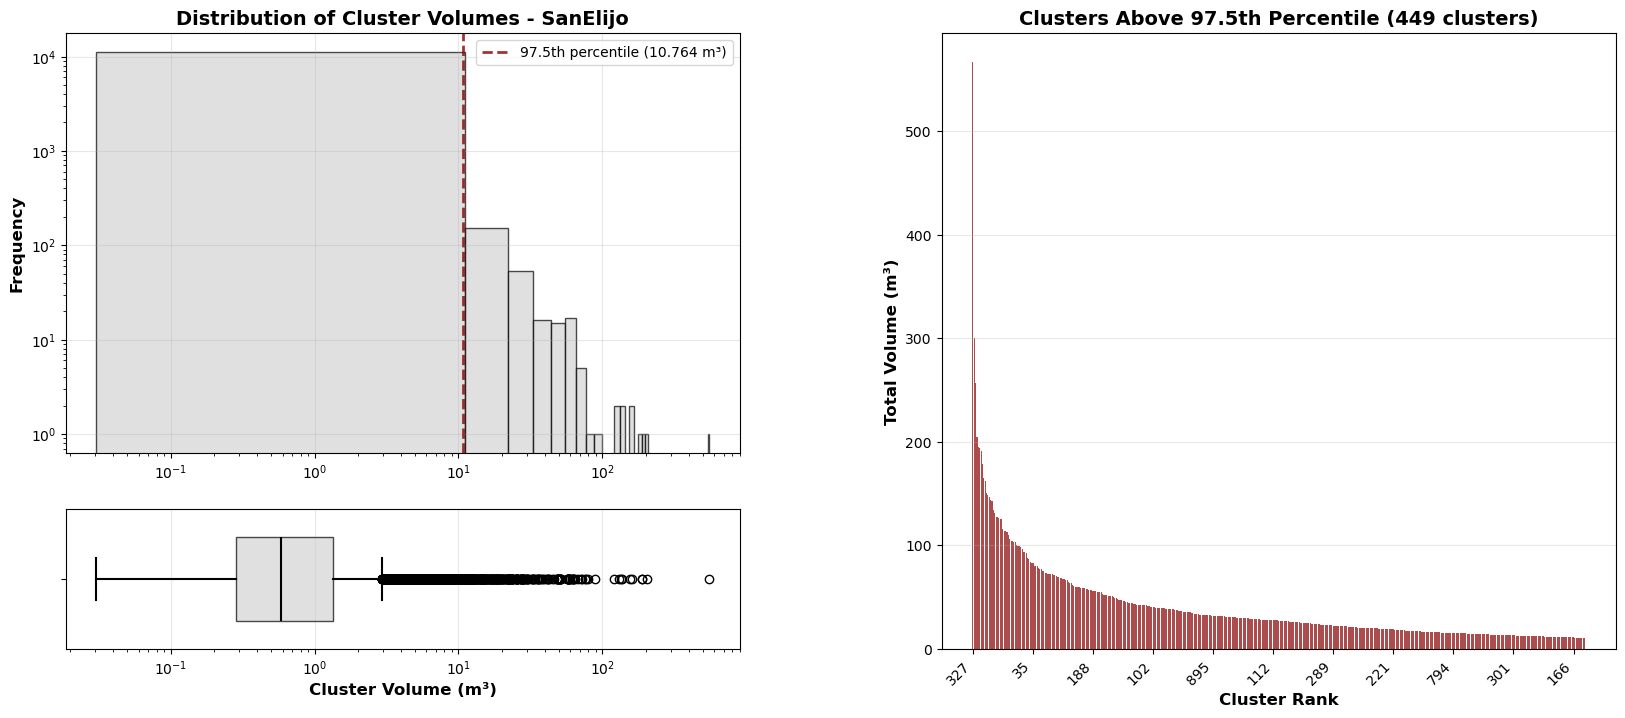


--- Summary Statistics ---
Total clusters: 1645
Total observations: 11414
Mean volume per observation: 1.8689 m³
Median volume: 0.5811 m³
Standard deviation: 8.2246 m³
Max volume: 551.3031 m³
Min volume: 0.0304 m³
25th percentile (Q1): 0.2832 m³
75th percentile (Q3): 1.3488 m³
90th percentile: 3.3562 m³
95th percentile: 6.1340 m³
97.5th percentile: 10.7639 m³
Interquartile Range (IQR): 1.0656 m³

--- Clusters Above 97.5th Percentile (449 total) ---
97.5th percentile threshold: 10.7639 m³

--- Top 10 Clusters by Total Volume (Above 97.5th Percentile) ---
 1. Cluster  327:  566.558 m³ ( 14 observations, mean: 40.4684 m³)
 2. Cluster   58:  299.911 m³ ( 30 observations, mean: 9.9970 m³)
 3. Cluster   77:  257.326 m³ ( 27 observations, mean: 9.5306 m³)
 4. Cluster  348:  204.769 m³ ( 12 observations, mean: 17.0641 m³)
 5. Cluster   64:  195.412 m³ ( 28 observations, mean: 6.9790 m³)
 6. Cluster  357:  194.524 m³ ( 12 observations, mean: 16.2104 m³)
 7. Cluster   81:  191.536 m³ ( 28 obser

/var/folders/wy/tbzk6rdx0_5d5y5p18xzqyfm0000gn/T/ipykernel_29584/3359318799.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


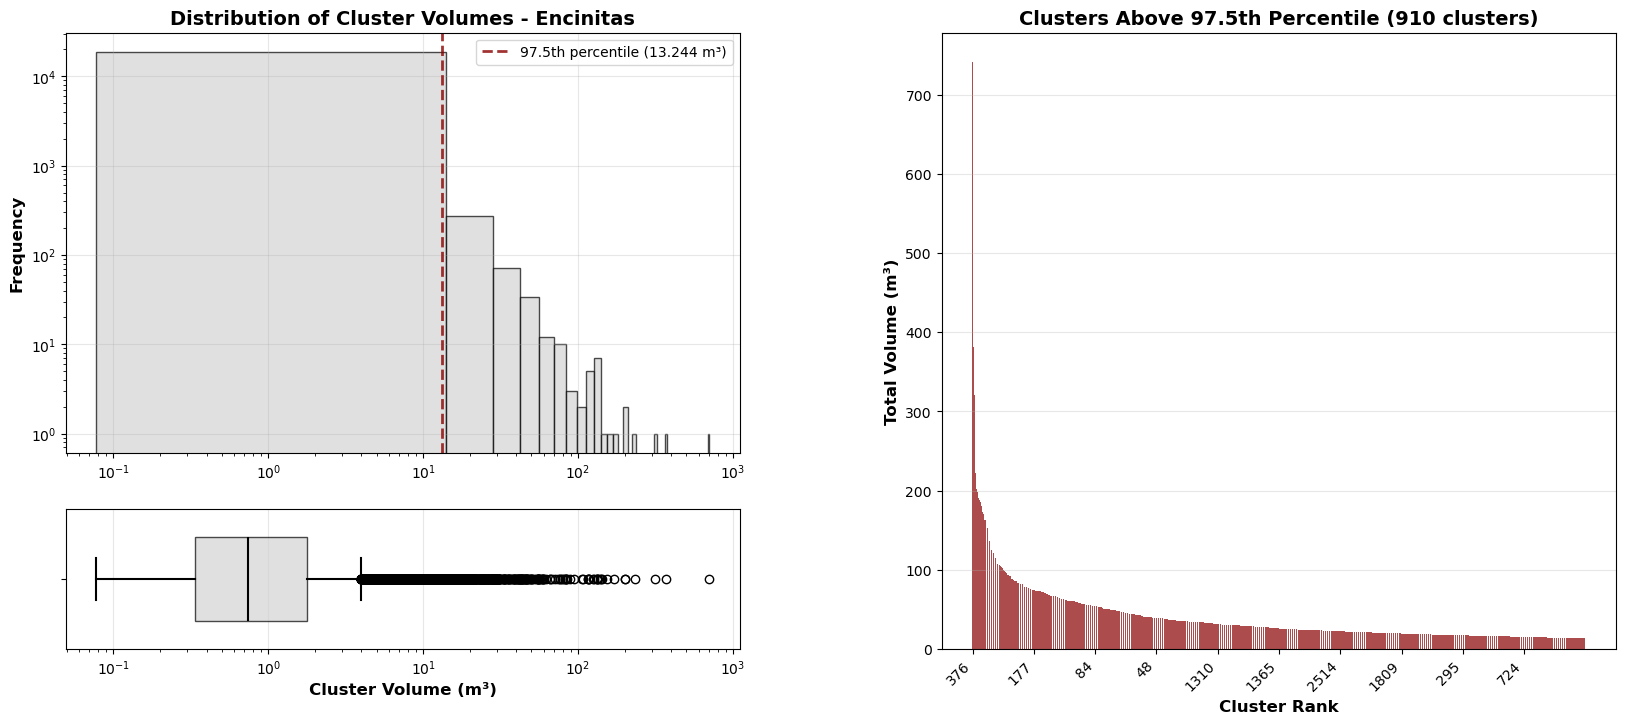


--- Summary Statistics ---
Total clusters: 2989
Total observations: 19211
Mean volume per observation: 2.2883 m³
Median volume: 0.7433 m³
Standard deviation: 9.0776 m³
Max volume: 700.4930 m³
Min volume: 0.0776 m³
25th percentile (Q1): 0.3357 m³
75th percentile (Q3): 1.7853 m³
90th percentile: 4.6230 m³
95th percentile: 8.1363 m³
97.5th percentile: 13.2443 m³
Interquartile Range (IQR): 1.4496 m³

--- Clusters Above 97.5th Percentile (910 total) ---
97.5th percentile threshold: 13.2443 m³

--- Top 10 Clusters by Total Volume (Above 97.5th Percentile) ---
 1. Cluster  376:  741.618 m³ ( 14 observations, mean: 52.9727 m³)
 2. Cluster 1756:  381.688 m³ (  4 observations, mean: 95.4221 m³)
 3. Cluster   36:  326.269 m³ ( 40 observations, mean: 8.1567 m³)
 4. Cluster 1781:  321.145 m³ (  4 observations, mean: 80.2862 m³)
 5. Cluster  125:  221.943 m³ ( 35 observations, mean: 6.3412 m³)
 6. Cluster 1575:  206.624 m³ (  2 observations, mean: 103.3119 m³)
 7. Cluster 1288:  201.764 m³ (  2 obs

In [14]:
cluster_volumes_tor, cluster_stats_tor, all_volumes_tor = analyze_cluster_volumes("Torrey")
cluster_volumes_sol, cluster_stats_sol, all_volumes_sol = analyze_cluster_volumes("Solana")
cluster_volumes_se, cluster_stats_se, all_volumes_se = analyze_cluster_volumes("SanElijo")
cluster_volumes_enc, cluster_stats_enc, all_volumes_enc = analyze_cluster_volumes("Encinitas")

In [17]:
# cluster_volumes_bl, cluster_stats_bl, all_volumes_bl = analyze_cluster_volumes("Blacks")

Combined dataset: 77302 total observations across 5 locations


/var/folders/wy/tbzk6rdx0_5d5y5p18xzqyfm0000gn/T/ipykernel_29584/1228975061.py:133: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


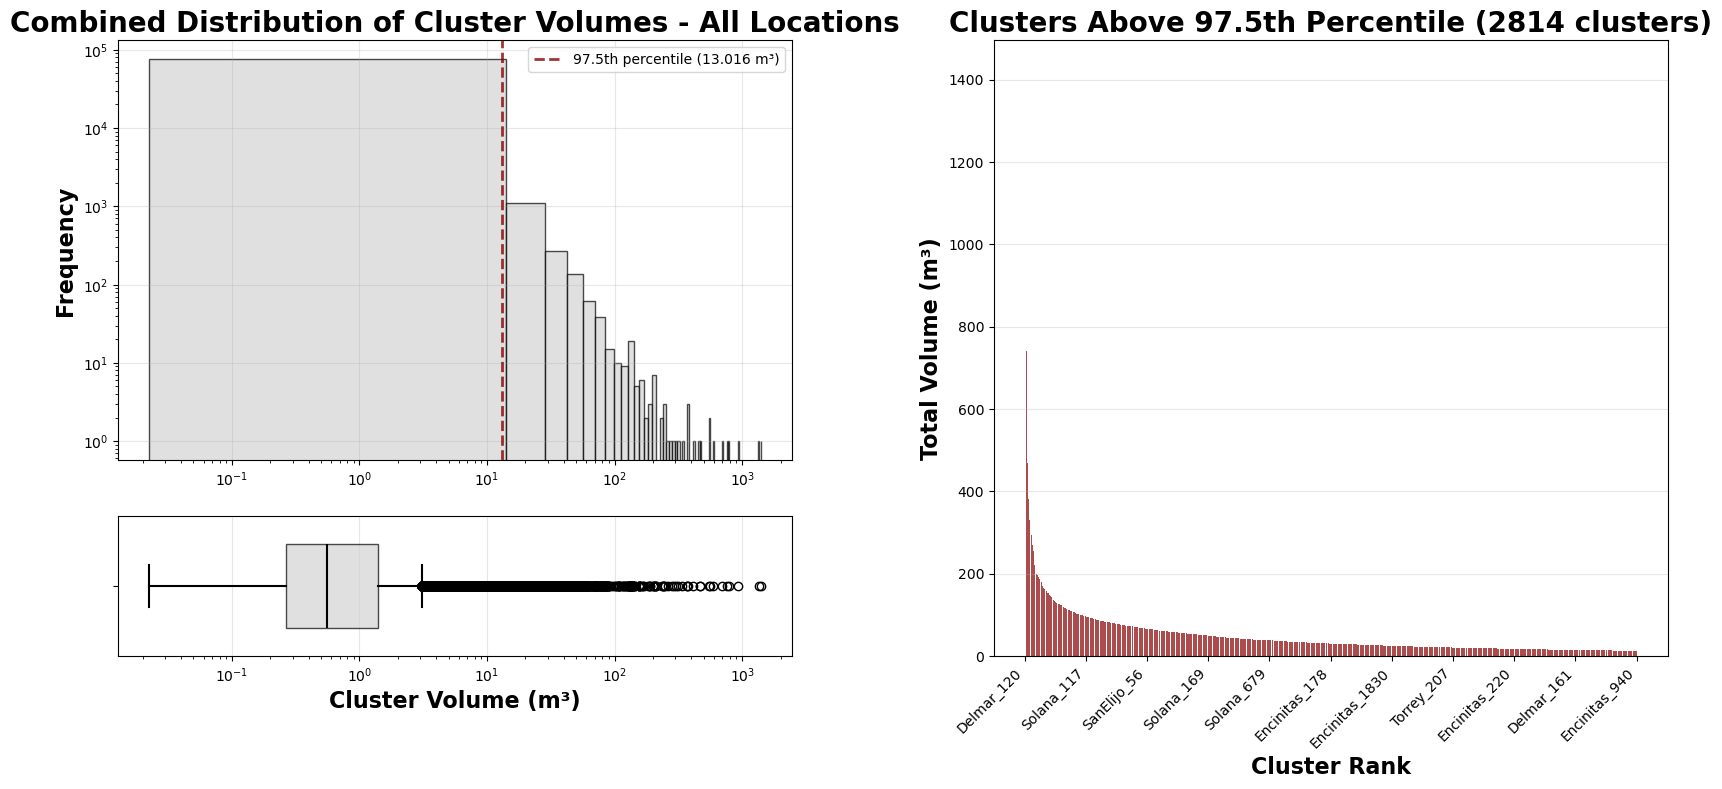


=== COMPREHENSIVE SUMMARY STATISTICS ===
Combined dataset: 77302 observations
Overall mean volume: 2.1582 m³
Overall median volume: 0.5611 m³
Overall std deviation: 12.6077 m³
Overall max volume: 1410.4714 m³
Overall min volume: 0.0222 m³
25th percentile (Q1): 0.2638 m³
75th percentile (Q3): 1.3862 m³
90th percentile: 4.1986 m³
95th percentile: 7.8100 m³
97.5th percentile: 13.0157 m³
Interquartile Range (IQR): 1.1224 m³

=== LOCATION COMPARISON ===
Delmar    : 13510 obs, mean:  1.8780 m³, median:  0.3212 m³, max: 1410.471 m³, total:  25372.1 m³
Torrey    : 17983 obs, mean:  1.6528 m³, median:  0.3851 m³, max: 1353.840 m³, total:  29723.1 m³
Solana    : 15184 obs, mean:  3.0587 m³, median:  1.1130 m³, max: 788.185 m³, total:  46442.8 m³
SanElijo  : 11414 obs, mean:  1.8689 m³, median:  0.5811 m³, max: 551.303 m³, total:  21332.1 m³
Encinitas : 19211 obs, mean:  2.2883 m³, median:  0.7433 m³, max: 700.493 m³, total:  43961.4 m³

=== CLUSTERS ABOVE 97.5TH PERCENTILE (2814 total) ===
97.5

In [18]:
def analyze_all_locations_combined():
    """
    Create a combined analysis figure using data from all locations.
    """
    locations = ["Delmar", "Torrey", "Solana", "SanElijo", "Encinitas"]
    all_location_volumes = []
    location_stats = {}
    
    # Collect all volumes from each location
    location_data = {
        "Delmar": all_volumes_dm,
        "Torrey": all_volumes_tor, 
        "Solana": all_volumes_sol,
        "SanElijo": all_volumes_se,
        "Encinitas": all_volumes_enc
    }
    
    # Combine all volumes and track by location
    combined_volumes = []
    location_labels = []
    
    for loc, volumes in location_data.items():
        combined_volumes.extend(volumes)
        location_labels.extend([loc] * len(volumes))
        location_stats[loc] = {
            'count': len(volumes),
            'mean': np.mean(volumes),
            'median': np.median(volumes),
            'total': sum(volumes),
            'max': max(volumes) if volumes else 0
        }
    
    print(f"Combined dataset: {len(combined_volumes)} total observations across {len(locations)} locations")
    
    # Calculate combined percentiles
    p90_combined = np.percentile(combined_volumes, 90)
    p95_combined = np.percentile(combined_volumes, 95)
    p975_combined = np.percentile(combined_volumes, 97.5)
    
    # Filter clusters above 97.5th percentile for combined data
    # Create combined cluster stats from all locations
    all_cluster_stats = {}
    for loc in locations:
        if loc == "Delmar":
            stats = cluster_stats_dm
        elif loc == "Torrey":
            stats = cluster_stats_tor
        elif loc == "Solana":
            stats = cluster_stats_sol
        elif loc == "SanElijo":
            stats = cluster_stats_se
        elif loc == "Encinitas":
            stats = cluster_stats_enc
        
        for cluster_id, cluster_data in stats.items():
            # Create unique ID by combining location and cluster ID
            unique_id = f"{loc}_{cluster_id}"
            all_cluster_stats[unique_id] = cluster_data
    
    # Filter clusters above 97.5th percentile
    above_975th_combined = [(cid, stats) for cid, stats in all_cluster_stats.items() 
                           if stats['total_volume'] >= p975_combined]
    above_975th_combined = sorted(above_975th_combined, key=lambda x: x[1]['total_volume'], reverse=True)
    
    # Create figure with same layout as individual analyses
    fig = plt.figure(figsize=(20, 8))
    
    # Create gridspec for custom layout with more space between histogram and boxplot
    gs = fig.add_gridspec(2, 2, height_ratios=[3, 1], width_ratios=[1, 1], hspace=0.2, wspace=0.3)
    
    # Top left: Combined histogram with log-log scale
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.hist(combined_volumes, bins=100, alpha=0.7, color='lightgray', edgecolor='black')
    ax1.set_ylabel('Frequency', fontsize=16, fontweight='bold')
    ax1.set_title('Combined Distribution of Cluster Volumes - All Locations', fontsize=20, fontweight='bold')
    ax1.set_xscale('log')  # Log scale for x-axis
    ax1.set_yscale('log')  # Log scale for y-axis
    ax1.grid(True, alpha=0.3)
    
    # Add only 97.5th percentile line to histogram
    ax1.axvline(p975_combined, color='darkred', linestyle='--', alpha=0.8, linewidth=2, 
                label=f'97.5th percentile ({p975_combined:.3f} m³)')
    ax1.legend()
    
    # Remove x-axis labels from histogram (will be on boxplot below)
    ax1.set_xticklabels([])
    
    # Bottom left: Combined boxplot (sharing x-axis with histogram)
    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
    box_data = ax2.boxplot(combined_volumes, vert=False, patch_artist=True, widths=0.6)
    box_data['boxes'][0].set_facecolor('lightgray')
    box_data['boxes'][0].set_alpha(0.7)
    
    # Customize boxplot appearance
    for element in ['whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(box_data[element], color='black', linewidth=1.5)
    
    ax2.set_xlabel('Cluster Volume (m³)', fontsize=16, fontweight='bold')
    ax2.set_xscale('log')  # Log scale for better visualization
    ax2.grid(True, alpha=0.3, axis='x')
    ax2.set_yticklabels([])  # Remove y-axis labels for boxplot
    
    # Right side: Bar chart spanning both rows - showing only events above 97.5th percentile
    ax3 = fig.add_subplot(gs[:, 1])
    cluster_ids_975th = [str(x[0]) for x in above_975th_combined]
    total_volumes_975th = [x[1]['total_volume'] for x in above_975th_combined]
    
    if total_volumes_975th:  # Only plot if there are clusters above 97.5th percentile
        bars = ax3.bar(range(len(cluster_ids_975th)), total_volumes_975th, color='darkred', alpha=0.7)
        ax3.set_xlabel('Cluster Rank', fontsize=16, fontweight='bold')
        ax3.set_ylabel('Total Volume (m³)', fontsize=16, fontweight='bold')
        ax3.set_title(f'Clusters Above 97.5th Percentile ({len(above_975th_combined)} clusters)', fontsize=20, fontweight='bold')
        
        # Set x-ticks - adjust spacing based on number of clusters
        if len(cluster_ids_975th) > 0:
            tick_spacing = max(1, len(cluster_ids_975th) // 10)  # Show at most 10 ticks
            x_tick_positions = range(0, len(cluster_ids_975th), tick_spacing)
            x_tick_labels = [cluster_ids_975th[i] for i in x_tick_positions]
            ax3.set_xticks(x_tick_positions)
            ax3.set_xticklabels(x_tick_labels, rotation=45, ha='right')
        
        # Add grid for better readability
        ax3.grid(True, alpha=0.3, axis='y')
        
        # All bars same color
        
    else:
        ax3.text(0.5, 0.5, 'No clusters above\n97.5th percentile', 
                 horizontalalignment='center', verticalalignment='center', 
                 transform=ax3.transAxes, fontsize=16, fontweight='bold')
        ax3.set_title('Clusters Above 97.5th Percentile (0 clusters)', fontsize=20, fontweight='bold')
    
    plt.tight_layout()
    # plt.savefig('combined_locations_cluster_volume_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print comprehensive summary
    print(f"\n=== COMPREHENSIVE SUMMARY STATISTICS ===")
    print(f"Combined dataset: {len(combined_volumes)} observations")
    print(f"Overall mean volume: {np.mean(combined_volumes):.4f} m³")
    print(f"Overall median volume: {np.median(combined_volumes):.4f} m³")
    print(f"Overall std deviation: {np.std(combined_volumes):.4f} m³")
    print(f"Overall max volume: {np.max(combined_volumes):.4f} m³")
    print(f"Overall min volume: {np.min(combined_volumes):.4f} m³")
    print(f"25th percentile (Q1): {np.percentile(combined_volumes, 25):.4f} m³")
    print(f"75th percentile (Q3): {np.percentile(combined_volumes, 75):.4f} m³")
    print(f"90th percentile: {p90_combined:.4f} m³")
    print(f"95th percentile: {p95_combined:.4f} m³")
    print(f"97.5th percentile: {p975_combined:.4f} m³")
    print(f"Interquartile Range (IQR): {np.percentile(combined_volumes, 75) - np.percentile(combined_volumes, 25):.4f} m³")
    
    print(f"\n=== LOCATION COMPARISON ===")
    for loc in locations:
        stats = location_stats[loc]
        print(f"{loc:10s}: {stats['count']:5d} obs, "
              f"mean: {stats['mean']:7.4f} m³, "
              f"median: {stats['median']:7.4f} m³, "
              f"max: {stats['max']:7.3f} m³, "
              f"total: {stats['total']:8.1f} m³")
    
    print(f"\n=== CLUSTERS ABOVE 97.5TH PERCENTILE ({len(above_975th_combined)} total) ===")
    print(f"97.5th percentile threshold: {p975_combined:.4f} m³")
    
    print(f"\n=== TOP 10 CLUSTERS BY TOTAL VOLUME (ABOVE 97.5TH PERCENTILE) ===")
    top_10_display = above_975th_combined[:10] if len(above_975th_combined) >= 10 else above_975th_combined
    for i, (cluster_id, stats) in enumerate(top_10_display):
        print(f"{i+1:2d}. Cluster {cluster_id}: {stats['total_volume']:8.3f} m³ "
              f"({stats['count']:3d} observations, mean: {stats['mean_volume']:.4f} m³)")
    
    return combined_volumes, location_stats

# Run the combined analysis
combined_volumes, location_stats = analyze_all_locations_combined()